In [2]:
%pip install transformers 
%pip install sklearn
%pip install datasets

You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys 

sys.path.append("/Users/max/Desktop/Dissertation/implementations/Disso-COLD/functions")

In [4]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments,DataCollatorWithPadding
from datasets import load_dataset, load_metric,Dataset
import torch
import numpy as np
from datasets import load_dataset
from utils import PrepareCorpus,AssessData
from sklearn.model_selection import train_test_split
from datasets import Dataset,load_dataset
import json
from re import template
from sklearn.model_selection import KFold

/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
number = range(50,150,50); _per_segment = range(200,400,100); max_input_length = 300

overlap = {"side":"both", "number": 50}; f1_score = load_metric("f1"); precision = load_metric("precision"); recall = load_metric("recall")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

def tokenize(batch):
    return bert_tokenizer(batch['text'], truncation=True, max_length=max_input_length,padding = True)

def compute_metrics(eval_pred):
    predictions, label = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return {"f1" :f1_score.compute(predictions = predictions, references = label, average = 'weighted'),
            "precision" : precision.compute(predictions = predictions, references = label, average = 'weighted'),
            "recall": recall.compute(predictions = predictions, references = label, average = 'weighted')}

def hp_space(trial):
  return {"per_device_train_batch_size": trial.suggest_discrete_uniform("per_device_train_batch_size", 8,32,8)
        ,"learning_rate": trial.suggest_float("learning_rate", 0.00001,0.00005, log = True)
        ,"num_train_epochs": trial.suggest_int("num_train_epochs",1,10)}

def bert_init():
  return BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

def id_2_labels(x,adict):
  """converts labels/classes into a number using a dictionary"""
  return adict[x]

def _indexing(alist):
  id = 0; indexed = {}
  for x in alist:
    for y in x:
      id +=1
      indexed[id] = y
  return indexed

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [6]:
imdb = load_dataset("imdb")
imdb

Reusing dataset imdb (/Users/max/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
100%|██████████| 3/3 [00:00<00:00, 92.79it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [7]:
#0 corresponds to negative review while 1 corresponds to positive reviews
label2text = {0:'negative', 1: 'positive'}

train_imdb = imdb['train']
test_imdb = imdb['test']
set(train_imdb['label'])

imdb_train_text = {i:x for i,x in enumerate(train_imdb['text'])}
imdb_test_text = {i:x for i,x in enumerate(test_imdb['text'])}

temp = []
imdb_labels_text_train = {i:temp.append(x) for i,x in zip(train_imdb['label'], train_imdb['text'])}

temp = []
imdb_labels_text_test = {i:temp.append(x) for i,x in zip(test_imdb['label'], test_imdb['text'])}

imdb_train_labels = {i:x for i,x in enumerate(train_imdb['label'])}
imdb_test_labels = {i:x for i,x in enumerate(test_imdb['label'])}

In [8]:
train_imdb_assess = AssessData(imdb_train_text, imdb_labels_text_train)
test_imdb_assess = AssessData(imdb_test_text, imdb_labels_text_test)

In [9]:
!pip install nltk
import nltk
nltk.download('punkt')

You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python3 -m pip install --upgrade pip' command.


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>


False

{'Too Long': 0, 'Long': 3012, 'BERT': 4759, 'Short': 17229}


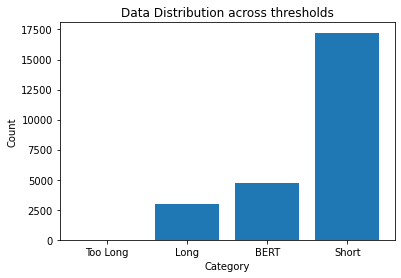

{'Too Long': 0, 'Long': 2803, 'BERT': 4639, 'Short': 17558}


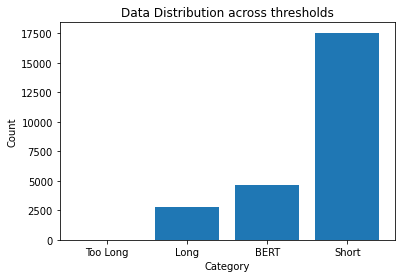

In [10]:
train_imdb_assess._create_distribution()
train_imdb_assess._visualise()

test_imdb_assess._create_distribution()
test_imdb_assess._visualise()

TRAINING ON THE FULL DATASET

In [11]:
train_set = train_imdb_assess._chunk(200, overlap=overlap)
train_index, train_text = zip(*train_set)

#Creates dictionary for train_index and train_text

train_index = {a:x for a,x in enumerate(train_index)}
train_text = {a:x for a,x in enumerate(train_text)}

In [12]:
test_set = test_imdb_assess._chunk(200, overlap=overlap)
test_index, test_text = zip(*test_set)

#Creates dictionary for test_index and test_text

test_index = {a:x for a,x in enumerate(test_index)}
test_text = {a:x for a,x in enumerate(test_text)}

In [13]:
train_index

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 2,
 19: 2,
 20: 2,
 21: 2,
 22: 3,
 23: 3,
 24: 3,
 25: 3,
 26: 3,
 27: 4,
 28: 4,
 29: 4,
 30: 4,
 31: 4,
 32: 4,
 33: 4,
 34: 4,
 35: 4,
 36: 4,
 37: 4,
 38: 5,
 39: 5,
 40: 5,
 41: 5,
 42: 5,
 43: 6,
 44: 6,
 45: 6,
 46: 6,
 47: 6,
 48: 7,
 49: 7,
 50: 7,
 51: 7,
 52: 7,
 53: 7,
 54: 7,
 55: 7,
 56: 7,
 57: 7,
 58: 8,
 59: 8,
 60: 8,
 61: 8,
 62: 8,
 63: 8,
 64: 8,
 65: 8,
 66: 8,
 67: 8,
 68: 8,
 69: 8,
 70: 8,
 71: 8,
 72: 8,
 73: 8,
 74: 9,
 75: 9,
 76: 9,
 77: 9,
 78: 9,
 79: 9,
 80: 9,
 81: 9,
 82: 10,
 83: 10,
 84: 10,
 85: 10,
 86: 10,
 87: 10,
 88: 10,
 89: 10,
 90: 10,
 91: 11,
 92: 11,
 93: 11,
 94: 11,
 95: 11,
 96: 12,
 97: 12,
 98: 12,
 99: 12,
 100: 12,
 101: 13,
 102: 13,
 103: 13,
 104: 13,
 105: 13,
 106: 14,
 107: 14,
 108: 14,
 109: 14,
 110: 14,
 111: 14,
 112: 14,
 113: 14,
 114: 14,
 115: 14,
 116: 14,
 117: 14,
 118: 15,
 1

In [14]:
list(test_index.values())[-1]

24999

In [15]:
#Creates dictionary of labels

train_chunked_label = {i:imdb_train_labels[x] for i,x in train_index.items()}
test_chunked_label = {i:imdb_test_labels[x] for i,x in test_index.items()}

In [16]:
train_set = {"train" : {"text": train_text.values(), "doc_id": train_index.values(), "labels": train_chunked_label.values()}}
test_set =  {"test" : {"text": test_text.values(), 'doc_id': test_index.values(), 'labels': test_chunked_label.values()}}

In [17]:
import pandas as pd

a = pd.DataFrame(train_set['train'])
b = pd.DataFrame(test_set['test'])

In [18]:
a

,text,doc_id,labels
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,0
1,d by U.S. customs if it ever tried to enter th...,0,0
2,Swedish drama student named Lena who wants to ...,0,0
3,about certain political issues such as the Vie...,0,0
4,"sex with her drama teacher, classmates, and ma...",0,0
...,...,...,...
203180,"zie!"". Time to end this review. I have to go t...",24998,1
203181,,24998,1
203182,The story centers around Barry McKenzie who mu...,24999,1
203183,eat Nation of ours there is something of a cul...,24999,1


In [19]:
#Modify types
a['text'] = a['text'].astype(str)
a['labels'] = a['labels'].astype(int)

b['text'] = b['text'].astype(str)
b['labels'] = b['labels'].astype(int)

In [20]:
train_set = Dataset.from_pandas(a)
test_set = Dataset.from_pandas(b)

In [21]:
train_set = train_set.shuffle(seed = 32)
#test_set = test_set.shuffle(seed = 32)

In [22]:
train_set = train_set.map(tokenize)

Parameter 'function'=<function tokenize at 0x2d28f09d0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████| 203185/203185 [01:45<00:00, 1917.34ex/s]


In [23]:
test_set = test_set.map(tokenize)

100%|██████████| 199213/199213 [01:39<00:00, 1997.06ex/s]


In [24]:
split = train_set.train_test_split(test_size = 0.1)

In [25]:
split_train_set = split['train']
split_valid_set = split['test']

In [26]:
from sklearn.model_selection import KFold

fold = KFold(n_splits = 5)
fold = fold.split(train_set)

fold_train = []
fold_test = []

for i, j in fold:
  fold_train.append(i)
  fold_test.append(j)

temp_train_set = train_set.select(fold_train[0])
temp_test_set = train_set.select(fold_test[0])  

In [36]:
training_args = TrainingArguments("./[chunk]IMDB_BERT_131000", learning_rate=5e-5, per_device_train_batch_size=16, per_device_eval_batch_size=16, num_train_epochs=13, weight_decay=0.01)
results = []

data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer, max_length= 300, padding = True)

#Fine-tune
trainer = Trainer(model = model, 
                args = training_args,
                train_dataset= temp_train_set,
                eval_dataset= temp_test_set,
                tokenizer= bert_tokenizer,
                data_collator=data_collator,
                compute_metrics= compute_metrics)

trainer.train(resume_from_checkpoint= True) #131000

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 162548
  Num Epochs = 13
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 132080


KeyboardInterrupt: 

In [32]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 40637
  Batch size = 16


Trainer is attempting to log a value of "{'f1': 0.8097298646442376}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8171834374302338}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.8108620222949529}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.9385738968849182,
 'eval_f1': {'f1': 0.8097298646442376},
 'eval_precision': {'precision': 0.8171834374302338},
 'eval_recall': {'recall': 0.8108620222949529},
 'eval_runtime': 103.1435,
 'eval_samples_per_second': 393.985,
 'eval_steps_per_second': 24.626,
 'epoch': 13.0}

In [35]:
results = trainer.predict(test_set)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 199213
  Batch size = 16


In [36]:
test_pred = list(np.argmax(results.predictions, axis = 1))

In [38]:
import pickle

with open("imdb_final_output_pred.pkl", "wb") as outs:
  pickle.dump(test_pred, outs)

In [ ]:
while True:pass

INVESTIGATING INCORRECT PREDICTIONS

In [38]:
import pickle

In [40]:
with open("imdb_chunk_200_50_result.pkl", "rb") as ins:
    results_imdb_chunk = pickle.load(ins)

In [ ]:
results_imdb_chunk

In [ ]:
test_set['doc_id']

In [ ]:

orig = [(i,x,) for i,x in zip(test_set['doc_id'], test_set['labels'])]
pred = [(i,x,) for i,x in zip(test_set['doc_id'], results_imdb_chunk)]

comb = {}

In [ ]:
for item in set(test_set['doc_id']):
    comb[item] = []

for chunk in pred:
    doc_id = chunk[0]
    chunk_label = chunk[1]

    comb[doc_id].append(chunk_label)

In [ ]:
y = {i:len(x) for i,x in comb.items()}
max(y.values())

66

In [ ]:
comb

{0: [0, 0, 0, 1, 0, 0, 0, 1],
 1: [1, 1, 1, 0, 0, 1, 0, 1],
 2: [0, 0, 0, 0, 1],
 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
 4: [0, 0, 0, 1, 1],
 5: [0, 0, 0, 0, 0, 1],
 6: [1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
 7: [0, 0, 0, 0, 0, 1],
 8: [0, 0, 0, 0, 1],
 9: [0, 0, 0, 0, 0, 1],
 10: [0, 0, 0, 0, 1],
 11: [0, 0, 1, 1, 0, 1],
 12: [0, 0, 0, 1, 1],
 13: [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
 14: [0, 0, 0, 0, 1],
 15: [0, 0, 0, 1, 0, 1],
 16: [0, 0, 0, 1, 0, 0, 1, 1],
 17: [0, 0, 0, 1, 1, 1],
 18: [0, 0, 1, 1, 1, 0, 0, 1, 1],
 19: [1, 0, 0, 0, 0, 0, 0, 1],
 20: [0, 1, 0, 1, 0, 1],
 21: [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
 22: [0, 0, 0, 1, 1],
 23: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 24: [0, 0, 0, 0, 0, 0, 0, 1, 1],
 25: [0, 0, 0, 0, 0, 0, 1],
 26: [0, 0, 1, 0, 0, 0, 0, 1],
 27: [0, 0, 1, 1, 0, 0, 1],
 28: [0, 0, 0, 0, 1],
 29: [0, 1, 1],
 30: [0, 1, 1, 0, 0, 0, 1],
 31: [1, 0, 0, 0, 0, 0, 1],
 32: [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
 33: [1, 0, 0, 1, 0, 1],
 34: [1, 0, 0, 1, 1, 1, 1],


In [ ]:
from cmath import nan


chunk_array = np.zeros((len(comb.keys()), 66))
for i in range(len(comb.keys()) -1):
    for j in range(65):
        try:
            chunk_array[i][j] = comb[i][j]
        except IndexError:
            chunk_array[i][j] = nan

chunk_df = pd.DataFrame(chunk_array)
chunk_df['True_label'] = test_imdb['label']

chunk_df

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,True_label
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
2,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
4,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
24996,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
24997,1.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
24998,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1


In [ ]:
sys.path.append("/Users/max/Desktop/Dissertation/implementations/functions")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class RoBERT_Model_3(nn.Module):
    """ Make an LSTM model over a fine tuned bert model. Parameters
    __________
    bertFineTuned: BertModel
        A bert fine tuned instance
    """

    #added output_class to function

    def __init__(self, num_classes = 2):
        super(RoBERT_Model_3, self).__init__()
        self.lstm = nn.LSTM(66, 25000, num_layers=1, bidirectional=False)
        self.out = nn.Softmax(dim= num_classes)
    

    def forward(self,chunks):
        """ Define how to performed each call
        Parameters
        __________
        ids: array
            -
        mask: array
            - 
        token_type_ids: array
            -
        lengt: int
            -
        Returns:
        _______
        -
        """
        seq_lengths = torch.LongTensor([x for x in map(len, chunks)])
        #batch_emb_pad = nn.utils.rnn.pad_sequence(chunks, padding_value=-91, batch_first=True)
        #batch_emb = batch_emb_pad.transpose(0, 1)  # (B,L,D) -> (L,B,D)
         
        #lstm_input = nn.utils.rnn.pack_padded_sequence(chunk, seq_lengths.cpu().numpy(), enforce_sorted= False)

        packed_output, (h_t, h_c) = self.lstm(chunks,)  # (h_t, h_c))
#         output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, padding_value=-91)

        h_t = F.relu(h_t) #
        return self.out(h_t)

In [157]:
chunk_tensor = [torch.LongTensor(x) for x in list(comb.values())]
chunk_tens_array = torch.tensor(chunk_array)
#chunk_tensor.size()
chunk_tens_array.dim()

2

In [1]:
temp_Rmodel = RoBERT_Model_3()
temp_Rmodel.forward(chunk_tens_array)

NameError: name 'RoBERT_Model_3' is not defined

In [ ]:
with open("incorrect_index_512.pkl", "rb") as ins:
    incorrect_index_512 = pickle.load(ins)

with open("results_2_512.pkl", "rb") as ins:
    results_512 = pickle.load(ins)


len(incorrect_index_512)
incorrect_index_512 = check_wrong_preds(incorrect_index_512)
incorrect_labels_512 = [str(x['labels']) for x in incorrect_index_512]
plt.hist(incorrect_labels_512)

WITH 100 Overlap